In [34]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn.feature_selection as fs
from sklearn.svm import SVR

class DecimalScaler :
    def __init__(self) :
        self.dec = 0
        return
    
    def calculate(self, data) :
        return data / self.dec
    
    def fit(self, data) :
        self.dec = 10 ** np.array([len(i.split('.')[0]) for i in np.floor(data.max()).astype(str)])
        return
        
    def fit_transform(self, data) :
        self.fit(data)
        return self.calculate(data)
    
    def transform(self, data) :
        return self.calculate(data)
    
    def inverse_transform(self, data) :
        return data * self.dec

In [4]:
lookback = 48 * 2
interval = 1

def applyFeatureEngineering(data) :
    data.loc[:, "GHI"] = data["DHI"] + data["DNI"]    
    data = data[["Day", "Hour", "Minute", "DHI", "DNI", "RH", "WS", "T", "GHI", "TARGET"]]
    return data

train = pd.read_csv("./RawData/train/train.csv")
train = applyFeatureEngineering(train)
train.describe()


,Day,Hour,Minute,DHI,DNI,RH,WS,T,GHI,TARGET
count,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000
mean,547.000000,11.500000,15.000000,64.344121,234.792371,56.793102,2.456033,9.279928,299.136492,17.790630
std,316.102148,6.922252,15.000143,103.897125,349.684583,22.052875,1.426874,10.179741,392.456413,25.759955
min,0.000000,0.000000,0.000000,0.000000,0.000000,7.590000,0.000000,-19.000000,0.000000,0.000000
25%,273.000000,5.750000,0.000000,0.000000,0.000000,39.697500,1.400000,1.000000,0.000000,0.000000
50%,547.000000,11.500000,15.000000,0.000000,0.000000,57.600000,2.200000,9.000000,0.000000,0.000000
75%,821.000000,17.250000,30.000000,87.000000,469.000000,72.770000,3.200000,17.000000,655.000000,32.089890
max,1094.000000,23.000000,30.000000,528.000000,1059.000000,100.000000,12.000000,35.000000,1153.000000,99.913939


In [41]:
columnsIndex = np.array(range(train.columns.values.shape[0]))[np.isin(train.columns.values, ["TARGET", "DHI", "DNI", "RH", "WS", "T", "GHI"])]

trainFeature_2d = pd.DataFrame(train.iloc[:48 * 48 * 15, columnsIndex].reset_index(drop = True))
trainTarget_2d = train["TARGET"].iloc[:48 * 48 * 15]
trainTarget_2d = pd.DataFrame(trainTarget_2d.values.reshape(-1, 1), index = trainFeature_2d.index)

validFeature_2d = pd.DataFrame(train.iloc[48 * 48 * 15:, columnsIndex].reset_index(drop = True))
validTarget_2d = train["TARGET"].iloc[48 * 48 * 15:]
validTarget_2d = pd.DataFrame(validTarget_2d.values.reshape(-1, 1), index = validFeature_2d.index)

featureScaler = DecimalScaler()
targetScaler = DecimalScaler()

trainFeature_2d = pd.DataFrame(featureScaler.fit_transform(trainFeature_2d), index = trainFeature_2d.index)
trainTarget_2d = pd.DataFrame(targetScaler.fit_transform(trainTarget_2d), index = trainFeature_2d.index)

validFeature_2d = pd.DataFrame(featureScaler.transform(validFeature_2d), index = validFeature_2d.index)
validTarget_2d = pd.DataFrame(targetScaler.transform(validTarget_2d), index = validFeature_2d.index)

trainTarget_2d = trainTarget_2d.shift(-96).dropna().reset_index(drop = True)
validTarget_2d = validTarget_2d.shift(-96).dropna().reset_index(drop = True)

trainFeature_2d = trainFeature_2d.iloc[:trainFeature_2d.shape[0] - 96, :].reset_index(drop = True)
validFeature_2d = validFeature_2d.iloc[:validFeature_2d.shape[0] - 96, :].reset_index(drop = True)

In [51]:
linear = SVR()
linear.fit(trainFeature_2d[["DHI", "TARGET"]], trainTarget_2d.values.reshape(-1))

SVR()

In [52]:
linear.score(validFeature_2d[["DHI", "TARGET"]], validTarget_2d.values.reshape(-1))

0.6789384958585144

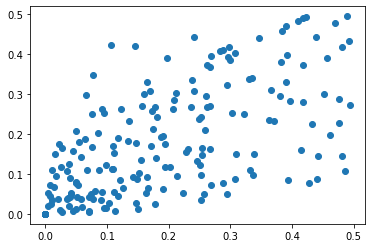

In [29]:
start = 0
end = 500

plt.scatter(trainFeature_2d["TARGET"].values[start:end], trainTarget_2d.values[start:end])

In [44]:
trainFeature_2d.columns

Index(['DHI', 'DNI', 'RH', 'WS', 'T', 'GHI', 'TARGET'], dtype='object')

In [50]:
fs.mutual_info_regression(trainFeature_2d[["DHI", "TARGET"]], trainTarget_2d.values.reshape(-1), n_neighbors = 15)

array([0.81350006, 0.87794181])

In [43]:
fs.f_regression(trainFeature_2d, trainTarget_2d.values.reshape(-1))

(array([32511.81032942, 19631.36150299, 18774.73165873,  1865.18284346,
        12286.04726395, 37781.24067545, 71557.22349635]),
 array([0., 0., 0., 0., 0., 0., 0.]))

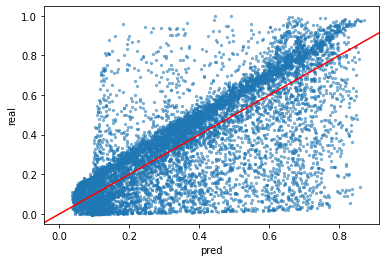

In [53]:
plt.scatter(linear.predict(validFeature_2d[["DHI", "TARGET"]]), validTarget_2d, alpha = .5, s = 5)
plt.xlabel("pred")
plt.ylabel("real")
plt.axline((0, 0), slope = 1, c = "red")